# EnvBayes Notebook #3.  Hierarchical Model for Stormwater

## Main Points
* Hierarchical models employ adaptive priors for categorical data, which enable the sharing of information across categories.  
* Adaptive priors can be especially useful for datasets with varying sample counts across categories.
* This notebook presents a hierarchical model for stormwater data using a gamma likelihood (gamma generalized linear model)

## 1. Background and Purpose

This notebook presents a hierarchical model for estimating nutrient concentrations in stormwater drawing from the radon model example (e.g., see [here](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html)) from Gelman and Hill, 2006.  

### Background

Nutrients from fertilizer, agricultural waste, natural processes, and other sources enter water bodies through stormwater runoff and impact the aquatic ecosystems.  For example, excess nutrient loading can increase the intensity of summer algal blooms which in turn impact oxygen levels in a water body.  Predicting the concentrations of nutrients in stormwater can be helpful for modeling and managing watersheds and receiving water bodies. 

Stormwater discharges can have strong geographic effects.  Nutrient loads are impacted by land usage within the catchment area for a stormwater outfall, with different loads associated with industrial, residential, agricultural, and forested landuse types. 

For this notebook example, stormwater data were gathered from multiple previous studies.  Stormwater outfalls were grouped in 12 geographical regions within a watershed to capture potential area-wide variations in nutrient loading (direct land use information was not available) and estimate nutrient concentrations in stormwater entering different areas of the harbor. 

### Data
This example dataset comes from an urban harbor nutrient loading study in the Pacific Northwest.  The study used historical data collected from multiple sources.  As such, the data have variable sample counts across categories.  We will analyze nitrate in stormwater for this example analysis.  These data were part of a real study, but the place names have been removed for this simplified example. 

Here is a summary of the data:    

Imports

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import datetime
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)
import pymc as pm

import arviz as az
pd.set_option('display.colheader_justify', 'center')

def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = ' %s Percentile' % n
    return percentile_

data = pd.read_excel('data/nitrate_nitrite_stormwater.xlsx')
data['Detect'] = data.Detect_Y_N.replace({'Y':True, 'N':False})
areas = data.Area.unique()
areas.sort()
idxs = list(range(len(areas)))
data['Area_idx'] = data.Area.replace(dict(zip(areas, idxs)))

analyte='Nitrate'
data = data[data.Analyte==analyte]

Plot Data

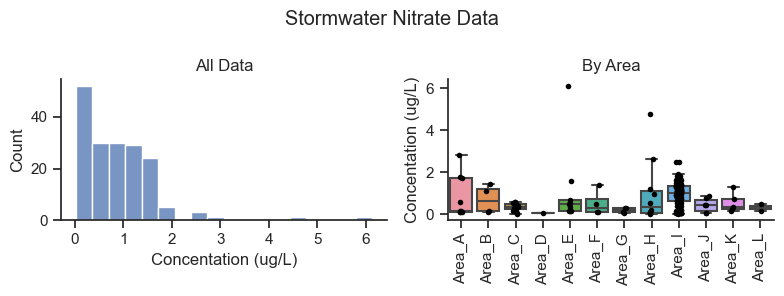

In [3]:
def box_strip(ax, data, analyte, category):
    plot_data = data[data.Analyte==analyte].sort_values(by=category)
    sns.boxplot(data = plot_data, fliersize=0, x=category, y='Value', ax=ax)
    sns.stripplot(data = plot_data, x=category, y='Value', color='black', size=4, ax=ax)

    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    ax.set(xlabel=None)
    ax.set_ylabel('Concentation (ug/L)')

def hist(ax, data, analyte):
    plot_data = data[data.Analyte==analyte]
    sns.histplot(data = plot_data,   x='Value', ax=ax)
    ax.set_xlabel('Concentation (ug/L)')


categories = ['Hist', 'Area']
fig, axes = plt.subplots(1, 2, figsize=(8,3))

for column, category in enumerate(categories):
    ax=axes[column]
    if category=='Hist':
        hist(ax, data, analyte)
        ax.set_title('All Data')
    else:
        box_strip(ax, data, analyte, category)
        ax.set_title('By '+category)
plt.suptitle('Stormwater Nitrate Data')
plt.tight_layout()

Summary statistics for all data combined.

In [4]:
def make_summary(data, by):
    summary = data[by+['Value']].groupby(by=by).agg(['count','mean','std','median', percentile(95), 'max']).Value
    summary.rename(columns = dict(zip(
        ['count', 'mean', 'std', 'median', ' 95 Percentile', 'max'],
        ['n', 'Mean', 'StDev', 'Median', '95th Pct', 'Max'])),
        inplace=True)
        
    summary['CV'] =  summary['StDev']/summary['Mean']

    summary['StdErr'] = summary.StDev / np.sqrt(summary.n)
    summary['Mean_5%CL'] = summary['Mean'] - summary.StdErr * 1.64485
    summary['Mean_95%CL'] = summary['Mean'] + summary.StdErr * 1.64485
    return summary


In [5]:
summary_pooled = make_summary(data, by=['Analyte'])
summary_pooled.round(2)

,n,Mean,StDev,Median,95th Pct,Max,CV,StdErr,Mean_5%CL,Mean_95%CL
Analyte,,,,,,,,,,
Nitrate,176,0.849,0.778,0.736,1.768,6.13,0.917,0.059,0.752,0.945


Summary statistics for data grouped by area.  

In [6]:
summary_area = make_summary(data, by=['Analyte', 'Area'])
summary_area.round(2)

n   Mean   StDev  Median  95th Pct   Max    CV    StdErr  \
Analyte Area                                                                
Nitrate Area_A    9  0.825  1.009   0.162    2.386   2.810  1.223   0.336   
        Area_B    4  0.696  0.684   0.618    1.398   1.450  0.982   0.342   
        Area_C   14  0.326  0.180   0.320    0.560   0.570  0.552   0.048   
        Area_D    1  0.073    NaN   0.073    0.073   0.073    NaN     NaN   
        Area_E    9  1.135  1.925   0.504    4.306   6.130  1.696   0.642   
        Area_F    4  0.517  0.609   0.296    1.253   1.390  1.177   0.304   
        Area_G    4  0.186  0.120   0.201    0.289   0.290  0.648   0.060   
        Area_H   10  1.044  1.541   0.353    3.807   4.770  1.476   0.487   
        Area_I  108  0.973  0.535   1.000    1.712   2.500  0.550   0.051   
        Area_J    6  0.433  0.358   0.439    0.857   0.887  0.828   0.146   
        Area_K    5  0.544  0.477   0.335    1.180   1.290  0.877   0.213   
        Area_L    2  0.327  0.231   0.327    0.474   0.490  0.705   0.163   

                Mean_5%CL  Mean_95%CL  
Analyte Area                           
Nitrate Area_A    0.272       1.378    
        Area_B    0.134       1.258    
        Area_C    0.247       0.404    
        Area_D      NaN         NaN    
        Area_E    0.080       2.191    
        Area_F    0.016       1.018    
        Area_G    0.087       0.285    
        Area_H    0.242       1.846    
        Area_I    0.888       1.057    
        Area_J    0.192       0.673    
        Area_K    0.193       0.895    
        Area_L    0.059       0.595

Key observations of the dataset: 
* The sample counts are highly variable across categories.  For example, for nitrate, Area I has the most data with 108 data points for nitrate, and Area D has only one data point.
* The distribution of data is positively skewed with occasional high concentrations in some areas.
* Much of the difference in nutrient concentration between areas could be attributable to noise.  However, some geographic areas appear to show trends compared to other geographic areas.  

Because the project team is interested in estimating concentrations for each subarea, we will use a model that can account for both the noise in the overall dataset and the samples counts and results in individual areas.

### Purpose
The purpose of this analysis is to estimate future mean concentrations of nitrate in different areas and the uncertainty in the estimate.

### Why Bayes?
A Bayesian approach was selected for this analysis because:
* It provides uncertainty estimates considering all information in the model.
* It allows a hierarchical model structure can share information across categories in the dataset.
* It can account for positive-only right-skewed data.

ANOVA is a frequentist method for comparing data across categories.  The primary reason that ANOVA is not used for this analysis is that it is a hypothesis testing framework.  The purpose of this analysis is *estimation with uncertainty,* rather than *hypothesis testing.*  Moreover, the parameter estimation function of ANOVA does not account skewed or hierarchical data.  

For reference, below are summary AOV tables from the Python StatsModels package.  The results suggest that it is valid to cautiously account for geographic area when interpreting the data ($PR(<F)$ is about 5%).      

In [7]:
import statsmodels.api as sm
aov_tables = []

model = sm.formula.ols('Value ~ Area', data=data[data.Analyte==analyte]).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
aov_table['Analyte'] = analyte
aov_tables.append(aov_table)
pd.concat(aov_tables, axis=0).round(3)


,sum_sq,df,F,PR(>F),Analyte
Area,11.559,11.0,1.826,0.053,Nitrate
Residual,94.390,164.0,NaN,NaN,Nitrate


Plotting Functions Used in the Code Later

In [8]:
def posterior_forest_area_plot(idata, model, data, factor_var = '1|Area', analyte = 'Nitrate', 
    observed_means_all = 'means', posterior_posterior_pred = 'posterior', CIs = True,
    title = 'Modeled and Observed Means with Confidence Intervals'):
    
    cols = data.Area.unique()
    cols.sort()

    if posterior_posterior_pred == 'posterior':
        df = pd.DataFrame(
            data=idata.posterior[factor_var].values.reshape(4000,12),
            columns=cols)
    elif posterior_posterior_pred == 'posterior_pred':
        df = pd.DataFrame(
            data=idata.posterior_predictive[factor_var].values.reshape(4000,12),
            columns=cols)
    elif posterior_posterior_pred == 'posterior_pred_log':
        df = pd.DataFrame(
            data=np.exp(idata.posterior_predictive[factor_var].values.reshape(4000,12)),
            columns=cols)
    else:
        print('check posterior_posterior_pred')

    # main forest plot
    fig, ax = plt.subplots( figsize=(6,6))
    az.plot_forest(dict(df), hdi_prob=.9, ax=ax)

    # add model means
    # mean_groups = idata.posterior['area_mu_mu'].values.mean()
    # plt.axvline(mean_groups,  linestyle=':', label='Model Mean for All Areas\n(Hyperprior [area_mu_mu] Mean)')
    summary_area = make_summary(data, by=['Analyte', 'Area'])  
    y_ticks = plt.yticks()[0]
    if observed_means_all == 'means':
        # add observed means
        mean_vals  = data.groupby('Area').mean()['Value']
        
        plt.scatter(x=mean_vals, y=y_ticks[::-1], label='Observed Group Mean and Count',
                    marker='+', color='red', s=50, 
                    zorder=1000)
        
        # add sample count labels
        
        ns = summary_area.loc[analyte,'n']

        for mean_val, y_tick, n in zip(mean_vals, y_ticks[::-1], ns):
            plt.text(mean_val+.03, y_tick, f'n={n}', c='red')
    
    elif observed_means_all == 'all':
        # add observed
        y_dict = dict(zip(areas, y_ticks[::-1]))
        plt.scatter(x=data.Value, y=data.Area.replace(y_dict), label='Observed',
                    marker='+', color='red', s=50, alpha=.5)
    
    elif observed_means_all == 'medians':

        # add observed medians
        median_vals  = data.groupby('Area').median()['Value']
        plt.scatter(x=median_vals, y=y_ticks[::-1], label='Observed Group Median and Count',
                    marker='+', color='black', s=100, 
                    zorder=1000)
        # add sample count labels
        
        ns = summary_area.loc[analyte,'n']

        for median_val, y_tick, n in zip(median_vals, y_ticks[::-1], ns):
            plt.text(median_val+.03, y_tick, f'n={n}', c='black')
    elif observed_means_all == 'all_medians':
        # add observed
        y_dict = dict(zip(areas, y_ticks[::-1]))
        plt.scatter(x=data.Value, y=data.Area.replace(y_dict), label='Observed',
                    marker='+', color='red', s=50, alpha=.5)
    
   

        # add observed medians
        median_vals  = data.groupby('Area').median()['Value']
        plt.scatter(x=median_vals, y=y_ticks[::-1], label='Observed Group Median',
                    marker='+', color='black', s=100, 
                    zorder=1000)
        

    else:
        print('need observed_means_all param to be "means" or "all"')


    # add global observed mean
    summary_pooled = make_summary(data, by=['Analyte'])
    mean_data = summary_pooled.at[analyte, 'Mean']
    plt.axvline(mean_data, c='red', linestyle=':', label='Observed Mean (All Data Pooled)')

    
    if CIs:
        plt.hlines(y=y_ticks[::-1]-.6, color='black', linestyles='dashed',
                    xmin = summary_area.loc[analyte,'Mean_5%CL'], 
                    xmax = summary_area.loc[analyte, 'Mean_95%CL'], 
                    label='90% Confidence Interval by Group')

        plt.hlines(y=-2,  color='black', linewidth = 3,
                    xmin=summary_pooled.at[analyte, 'Mean_5%CL'], 
                    xmax=summary_pooled.at[analyte, 'Mean_95%CL'], 
                    label='90% Confidence Interval All Data Pooled')
        plt.text(summary_pooled.at[analyte, 'Mean_95%CL']+.03,
                    -2,  'CI All Data Pooled', size= 8, c='black')


    # add legend entries for base forest plot
    handles, labels = ax.get_legend_handles_labels()

    handle90 = mlines.Line2D([], [] )
    handle50 = mlines.Line2D([], [], linewidth=3, marker='o', 
                markerfacecolor='white', markersize=5 )
    
    label90 = 'Model 90% Highest Density Interval (HDI)'
    label50 = 'Model 50% HDI, o = Median'
    handles.insert(0, handle50)
    labels.insert(0, label50)
    handles.insert(0, handle90)
    labels.insert(0, label90)
    
    
    ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1,.5))

    # adjustments
    plt.xlim(-.5, 2.5)
    plt.ylim(-3)
    plt.grid(axis='x')
    ax.set_title(title)
    ax.set_xlabel('Concentration (ug/L)')

    return fig, ax



In [37]:
def plot_predictive(plot_data, prior_posterior, title, fliersize,
                   conc_limits=(0,10)):
    fig, axes = plt.subplots(1,2, figsize=(6,2.5))
    
    ax=axes[0]
    sns.histplot(plot_data[prior_posterior], element="step",
                 stat='density', label=prior_posterior, ax=ax)
    sns.histplot(plot_data.Observed.dropna(), element="step",
                 label='Observed', stat='density', ax=ax)
    ax.legend()
    ax.set_xlabel('Concentration (ug/L)')
    ax.set_ylim(0,1)
    ax.set_xlim(conc_limits)

    ax=axes[1]
    sns.boxplot(plot_data, fliersize=fliersize)  
    ax.set_ylim(conc_limits)
    ax.set_ylabel('Concentration (ug/L)')
    plt.suptitle(title)
    plt.tight_layout()


## 2. Model Description

The model is a regression with one factor: geographic area.  

$$
C = \beta[area] + \epsilon
$$

$C$ is the concentration, $\beta_{area}$ is the regression coefficient indexed by area, and $\epsilon$ represents the error term around the regression estimate.  The model is fit independently for each chemical.

### Prior Distributions for $\beta$
Adaptive priors will be used for this analysis, so that information can be shared across categories.  This is also called a "partial pooling" model because categorical data is neither completely combined (i.e., no categories), nor completely separated by category (i.e., independent categories). 

The prior for $\beta[area]$ will be a normal distribution, and the hyperpriors will be normal and exponential distributions:  
  
$\beta[area] \sim Normal(\mu_{\beta}, \sigma_{\beta})$   
$\mu_{\beta} \sim Normal(Mean_{data}, SE_{data})$   
$\sigma_{\beta} \sim Exponential(1)$

$\mu_{\beta}$ is a Normal distribution with a $\mu$ equal to the mean of the data and $\sigma$ equal to the standard error ($SE$) of the data, selected to be consistent with the pooled dataset.  

$\sigma_{\beta}$ is the variation across groups.  As $\sigma_{\beta}$ goes to zero, the model becomes a complete pooling model, and as $\sigma_{\beta}$ goes to infinity, the model goes toward an unpooled model.  Based on experience with hierarchical models, an exponential distribution with $\lambda = 1$ is a good starting place for the model. 

Note that normal hyperpriors will be truncated at 0 to provide positive-only support, consistent with concentration data and the gamma likelihood described below.  

This approach can be described as adaptive priors with weakly informative hyperpriors.  The values of the prior parameters that will be specified in the model are as follows:   

In [10]:
summary_pooled[['Mean', 'StdErr' ]].round(4)

,Mean,StdErr
Analyte,,
Nitrate,0.8485,0.0587


Alternative prior specifications will be compared in Appendix B.

### Likelihood Function for $C$
The likelihood function represents the shape of the error, $\epsilon$ (i.e., noise or spread) of $C_{obs}$ around the regression prediction provided by $\beta[area]$.  For this analysis, we will use a gamma distributed likelihood.  The gamma distribution has several benefits in this setting, including the following:
* It has positive-only distribution support, consistent with the physical properties of concentrations.
* It has positive-skew, consistent with the dataset (and many environmental datasets).  
* The thickness of the upper tail can be varied in shape.    
* The gamma distribution is commonly parameterized as heteroskedastic with a constant coefficient of variation (i.e., standard deviation is proportional to the mean).  This is consistent with observations this dataset.  

The gamma distribution will be parameterized with the arithmetic mean, $\mu$ and the coefficient of variation $cv$ to be more interpretable for scientists who are accustomed to means and standard deviations.    

$CV \sim Normal(CV_{data}, CV_{data})$  
$C_{area} \sim Gamma(\mu= \beta[area], \sigma=CV*\beta[area])$

The model will truncate the normal distribution at 0 for $CV$ to ensure positive-only values.  

The prior for $CV$ is weakly informative.  Other likelihood functions will be compared in Appendix B.  

The prior values are as follows:

In [11]:
summary_pooled[['CV']].round(2)

,CV
Analyte,
Nitrate,0.92


The model can be referred to as gamma general linearized model with an identity link function and hierarchical priors.    

### Complete Model Specification
The complete model specification in Pymc3 is as follows.  

In [12]:
# Extract prior values for use in the notebook.
analyte = 'Nitrate'

# prior values
mean_data = summary_pooled.at[analyte, 'Mean']
se_data = summary_pooled.at[analyte, 'StdErr']
cv_data = summary_pooled.at[analyte, 'CV']

# observed data
obs_data = data[data.Analyte==analyte]

Pymc Model

In [13]:
with pm.Model() as hierarchical_stormwater_nitrate:
    # Data
    C_obs = pm.MutableData('C_obs', obs_data.Value.values)
    area_idx = pm.MutableData('area_idx', obs_data.Area_idx.values)
    
    # Hyperpriors
    area_mu_mu = pm.TruncatedNormal('area_mu_mu', mu=mean_data, sigma=se_data, lower=0)
    area_mu_sigma= pm.Exponential('area_mu_sigma', 1) 

    # Prior
    area_mu = pm.TruncatedNormal('area_mu', mu=area_mu_mu, sigma=area_mu_sigma, lower=0, 
                                 shape=len(areas))

    # Prior coefficient of variation
    cv = pm.TruncatedNormal('cv', mu=cv_data, sigma=cv_data, lower=0)
    # Likelihood  
    mu = area_mu[area_idx]    # Indexed mu for each datapoint
    pm.Gamma('C_modeled', mu=mu, sigma=cv*mu, observed=C_obs)
hierarchical_stormwater_nitrate

   area_mu_mu ~ TruncatedNormal(0.849, 0.0587, 0, inf)
area_mu_sigma ~ Exp(f())
      area_mu ~ TruncatedNormal(area_mu_mu, area_mu_sigma, 0, inf)
           cv ~ TruncatedNormal(0.917, 0.917, 0, inf)
    C_modeled ~ Gamma(f(area_mu, cv), f(area_mu, cv))

Graphical summary of the model.  

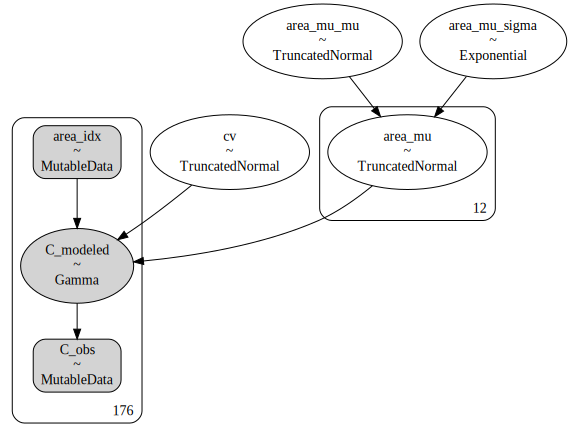

In [14]:
pm.model_to_graphviz(hierarchical_stormwater_nitrate)

The numbers at the bottom right of the plates show the shape of the variables.  For example, area_mu is being calculated for 12 different areas, whereas, there is only one coefficient of variation (cv) used for the entire model.  176 total samples are fit used to fit the model.  

## 3. Results

In [15]:
with hierarchical_stormwater_nitrate:
    trace = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [area_mu_mu, area_mu_sigma, area_mu, cv]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 103 seconds.


Plot results

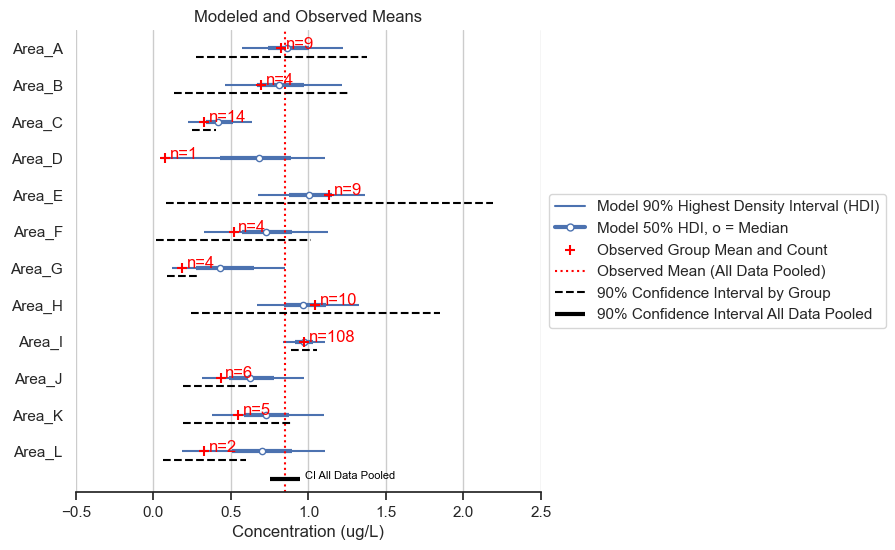

In [16]:
fig, ax = posterior_forest_area_plot(trace, hierarchical_stormwater_nitrate,
            obs_data, factor_var='area_mu',
            title='Modeled and Observed Means')

I'll run through the components of the figure and highlight some main points in the results.  
* The blue lines show the results of the statistical model.  These depict the highest density intervals (HDI) for the posterior mean concentration for each area.  90% of the predicted mean falls within the thinner blue line, and 50% of the predicted mean falls within the thicker blue line.  For example, the model predicts that the mean of Area A is between about 0.6 and 1.3 with 90% accuracy, and between 0.7 and 1.0 with 50% accuracy.     
* The red pluses show the mean of the data and the sample count for each area.  This information is helpful for understanding how the model inferred the posterior distributions for each area.
* Notice that sample count impacts the width of the HDI.  Area I has higher certainty than Area D, for example.  
* Notice that sample count also impacts the degree to which the observed mean impacts the model-predicted mean.  For example, Area C has a higher observed mean than Area D, however, Area C has a lower modeled mean than Area D.  This is because there were 14 data points for Area C and only one data point for Area D, so there is more evidence for a lower concentration in Area C compared to Area D.  
* In all cases, the predicted mean is drawn toward the global mean for all areas, referred to as "shrinkage."
* The vertical red dotted line is a mean of all the data.  Shrinkage generally goes to this line. 
* The frequentist 90% confidence intervals (calculated as +/- 1.64 times the standard error) for the individual areas vary from unreasonably narrow (e.g., Area G) to unreasonably wide (e.g., Area E).  The hierarchical model, on the other hand, gives a range of values that intuitively make sense when considering all the data.

## 4. Discussion
To summarize, the model uses probability theory to estimate differences between groups that accounts for group data, global data, sample size, skewness and positive-only chemical concentrations.  The resulting model is able to provide predicted means and uncertainty in the predicted means for all groups.  The predicted means for the groups exhibit "shrinkage" toward the global mean.  The Bayesian HDIs are smaller that frequentist confidence intervals for some groups and larger for other groups, depending on the sample size and variance for the groups, and the degree of shrinkage for each group.  

This technique was demonstrated for a simple estimation problem, but the technique can be extended for any dataset that has hierarchical structure.  For example, by performing multiple regression on both area and season. 

The next sections include the Bayesian model checking, including MCMC Diagnostics, Prior and posterior predictive checks, and sensitivity to alternative parameterizations.  These "appendices" were described in the previous notebook and draw from the common best practices in Bayesian analysis.  

## A.  MCMC Diagnostics

As discussed in the previous notebook, the key diagnostic to show that the MCMC inference converged is the r_hat statistic, which measures the similarity between MCMC chains.  Based on the rule of thumb, the r_hat values should be all less than or equal to 1.01.  

The key diagnostic to show that the MCMC inference achieved sufficient resolution is the effective sample size (ESS) which is a measure of the MCMC samples adjusted for colinearity within the chain.  Based on a rule of thumb, the effective sample size should be greater than 400.  

The following table calculates the diagnostics for the MCMC inference showing that they are all within an appropriate range.    

In [17]:
var_names = ['area_mu', 'cv', 'area_mu_mu', 'area_mu_sigma']
az.summary(trace, var_names=var_names)[['r_hat', 'ess_bulk', 'ess_tail']]

,r_hat,ess_bulk,ess_tail
area_mu[0],1.00,5049.0,2877.0
area_mu[1],1.00,4876.0,2837.0
area_mu[2],1.00,2051.0,1436.0
area_mu[3],1.00,2452.0,2103.0
area_mu[4],1.00,4177.0,2537.0
area_mu[5],1.00,5189.0,2676.0
area_mu[6],1.00,2429.0,2615.0
area_mu[7],1.00,3544.0,2333.0
area_mu[8],1.00,4859.0,3306.0
area_mu[9],1.00,4423.0,3381.0


Visual checks of the MCMC trace can help to identify potential issues in the MCMC sample.  The left-hand plots show the probability distributions for each variable and each chain to see if they coincide.  The right-hand plots show MCMC samples over time, which should look similar to white noise.  The MCMC sampler will also provide warning markers called "divergences" to help the practicioner to identify potential issues with the MCMC sample.  

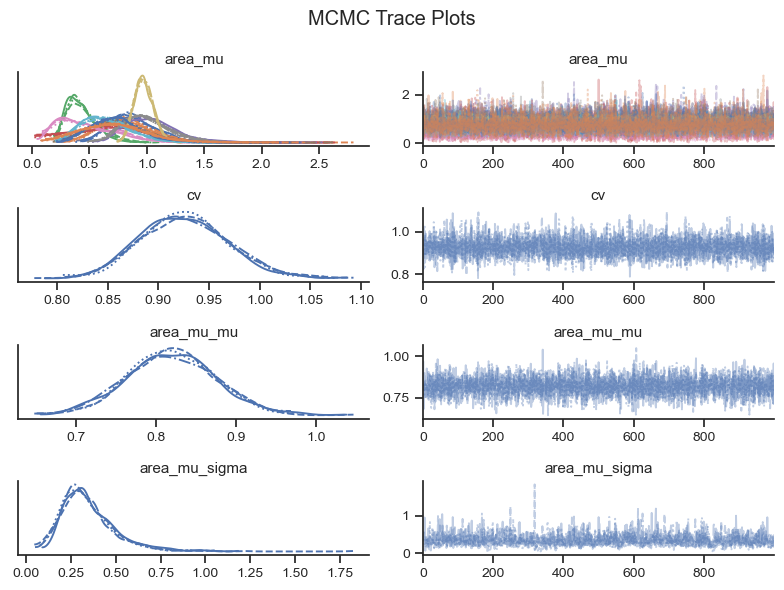

In [18]:
az.plot_trace(trace, var_names=var_names, figsize=(8,6))
plt.suptitle('MCMC Trace Plots')
plt.tight_layout()

Based on the visual check of the trace plots above, the chains have converged and the sample explored the sample space.  Depending on the exact MCMC run that finds its way onto the website, there may be 10 or so divergence warnings provided by the sampler.  However, based on the other diagnostics, it is safe to ignore the warnings from the MCMC sampler.

## B. Prior and Posterior Predictive Checks

### Prior Predictive Check

The prior predictive check helps to show that the selection of priors is in the range of the data and to identify if the prior is biasing the results.   

In [19]:
with hierarchical_stormwater_nitrate:
    prior = pm.sample_prior_predictive(500)

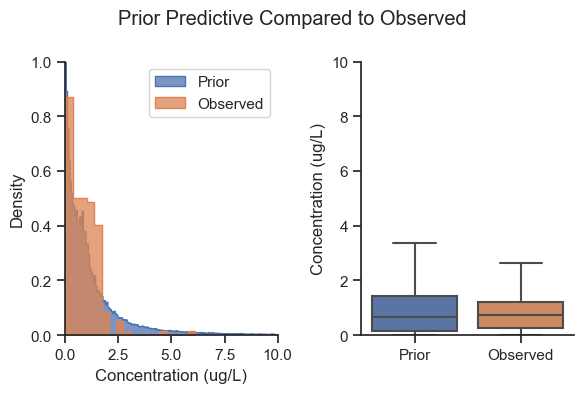

In [20]:
plot_data = pd.DataFrame()
plot_data['Prior'] = prior.prior_predictive['C_modeled'].values.flatten()
missing_n = (len(prior.prior_predictive['C_modeled'].values.flatten()) -
            len(obs_data.Value.values))
plot_data['Observed'] = list(obs_data.Value.values) + [np.nan]*missing_n

plot_predictive(plot_data, prior_posterior='Prior', fliersize=0,
                title='Prior Predictive Compared to Observed')

Based on the plot above, the prior predictive is within the range of the data.  The prior predictive values are a narrow version of weakly informative adaptive priors.  Note that while the priors more/less match the shape of the entire dataset, they are the same for each area, therefore, the posterior picks up the difference between the areas. 

### Posterior Predictive Check

The posterior predictive check is where the fit model is used to general simulated data to see if it has similar characteristics to the observed data.  

The following graphic presents the range of posterior predicted values compared to the observed concentrations.  

In [21]:
area_idxs  = obs_data.Area_idx.unique()
area_idxs.sort()
hierarchical_stormwater_nitrate.set_data('area_idx', area_idxs)
with hierarchical_stormwater_nitrate:
    post_pred = pm.sample_posterior_predictive(trace)

(0.0, 7.0)

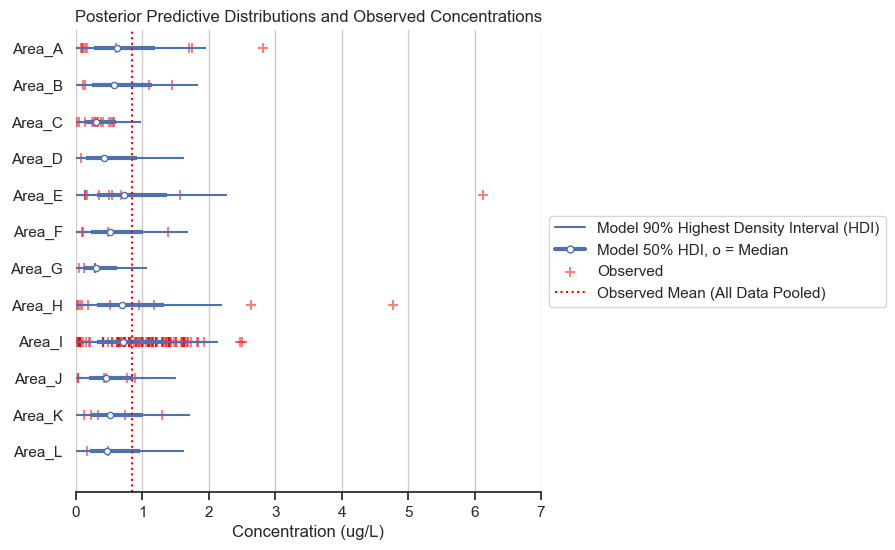

In [22]:
fig, ax = posterior_forest_area_plot(post_pred, hierarchical_stormwater_nitrate,
            obs_data, factor_var='C_modeled', observed_means_all = 'all', 
             posterior_posterior_pred = 'posterior_pred', CIs=False,
            title='Posterior Predictive Distributions and Observed Concentrations')
ax.set_xlim(0, 7)

The posterior predictive distributions are reasonable when compared to the observed data.  The following histogram and box plots offer another view on the same information.

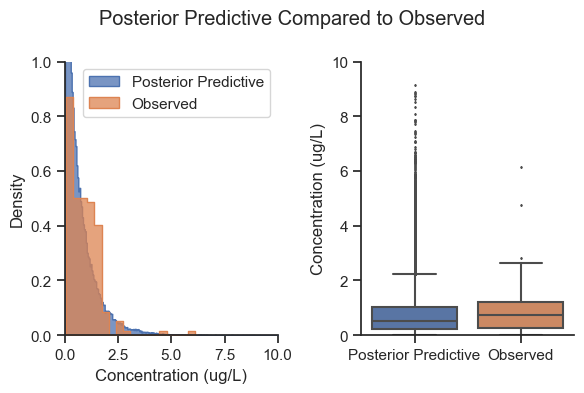

In [23]:
plot_data = pd.DataFrame()
plot_data['Posterior Predictive'] = post_pred.posterior_predictive['C_modeled'].values.flatten()
missing_n = (len(plot_data['Posterior Predictive']) -
            len(obs_data.Value.values))
plot_data['Observed'] = list(obs_data.Value.values) + [np.nan]*missing_n

plot_predictive(plot_data, prior_posterior='Posterior Predictive', fliersize=1,
                title='Posterior Predictive Compared to Observed')
plt.tight_layout()

Note that the posterior predictive sampled all areas equally, whereas the observed data is biased by area (i.e., the observed data had different sample counts by area), so this is not an exact apples to apples comparison.  Nevertheless, the shape of the posterior is generally consistent with the data.  

## C.  Sensitivity to Alternative Specifications

The key modeling decisions that were made in developing the partial pooling model are the choice prior parameter values and the choice likelihood function.  Alternative models will be fit and compared below.    

### Wider Prior Specification

The priors were somewhat narrow, here is a model specified with wider prior parameter values:

In [24]:
with pm.Model() as hierarchical_stormwater_nitrate_wider_priors:
    # Data
    C_obs = pm.MutableData('C_obs', obs_data.Value.values)
    area_idx = pm.MutableData('area_idx', obs_data.Area_idx.values)
    
    # Hyperpriors
    area_mu_mu = pm.TruncatedNormal('area_mu_mu', mu=mean_data, sigma=mean_data, lower=0)
    area_mu_sigma= pm.Exponential('area_mu_sigma', lam=.5) 

    # Prior
    area_mu = pm.TruncatedNormal('area_mu', mu=area_mu_mu, sigma=area_mu_sigma, lower=0, 
                                 shape=len(areas))

    # Prior coefficient of variation
    cv = pm.TruncatedNormal('cv', mu=cv_data*2, sigma=cv_data*2, lower=0)
    # Likelihood  
    mu = area_mu[area_idx]    # Indexed mu for each datapoint
    pm.Gamma('C_modeled', mu=mu, sigma=cv*mu, observed=C_obs)

hierarchical_stormwater_nitrate_wider_priors

   area_mu_mu ~ TruncatedNormal(0.849, 0.849, 0, inf)
area_mu_sigma ~ Exp(f())
      area_mu ~ TruncatedNormal(area_mu_mu, area_mu_sigma, 0, inf)
           cv ~ TruncatedNormal(1.83, 1.83, 0, inf)
    C_modeled ~ Gamma(f(area_mu, cv), f(area_mu, cv))

Note that the wider prior for area_mu_sigma is $\lambda=0.5$ compared to $\lambda=1.0$.  

In [25]:
with hierarchical_stormwater_nitrate_wider_priors:
    trace = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [area_mu_mu, area_mu_sigma, area_mu, cv]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 114 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9535, but should be close to 0.99. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9651, but should be close to 0.99. Try to increase the number of tuning steps.


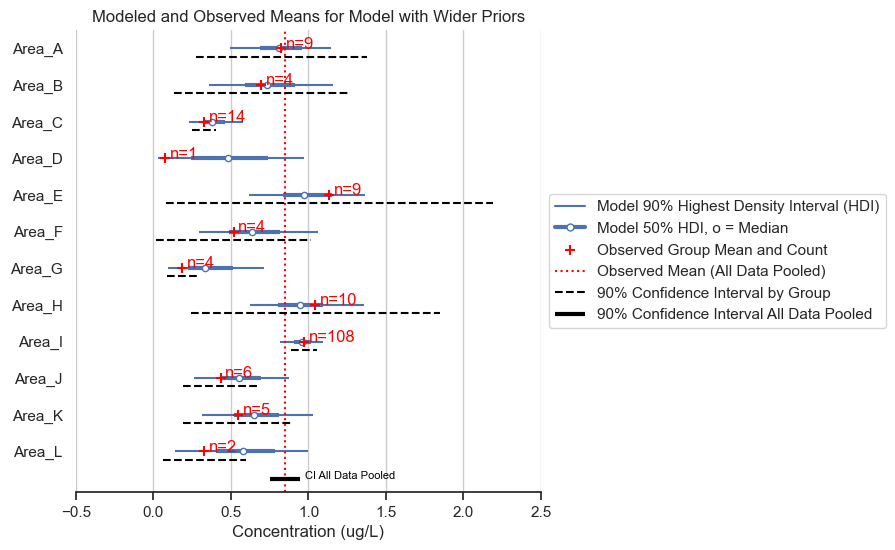

In [26]:
fig, ax = posterior_forest_area_plot(trace,
            hierarchical_stormwater_nitrate,
            obs_data, factor_var='area_mu',
            title='Modeled and Observed Means for Model with Wider Priors')

Visually, the results are the same as those above.  

### Comparison to Different Likelihood Functions
The base model has a gamma likelihood to approximate the skewed distibution in the data.  Let's compare to two other common likelihoods, normal and lognormal.  

#### Normal Likelihood
The normal likelihood model will allow negative values, and the error term will be homoskedastic (constant regardless of mu) for consistency with the most common normal likelihood parameterization.   

In [27]:
with pm.Model() as hierarchical_stormwater_nitrate_normal_like:
    # Data
    C_obs = pm.MutableData('C_obs', obs_data.Value.values)
    area_idx = pm.MutableData('area_idx', obs_data.Area_idx.values)
    
    # Hyperpriors
    area_mu_mu = pm.Normal('area_mu_mu', mu=mean_data, sigma=mean_data)
    area_mu_sigma= pm.Exponential('area_mu_sigma', 1) 

    # Prior
    area_mu = pm.Normal('area_mu', mu=area_mu_mu, sigma=area_mu_sigma, 
                                 shape=len(areas))

    # Prior coefficient of variation
    sigma = pm.TruncatedNormal('sigma', 
                        mu=cv_data*mean_data, 
                        sigma=cv_data*mean_data, 
                        lower=0)
    # Likelihood  
    mu = area_mu[area_idx]    # Indexed mu for each datapoint
    pm.Normal('C_modeled', mu=mu, sigma=sigma, observed=C_obs)

hierarchical_stormwater_nitrate_normal_like

   area_mu_mu ~ N(0.849, 0.849)
area_mu_sigma ~ Exp(f())
      area_mu ~ N(area_mu_mu, area_mu_sigma)
        sigma ~ TruncatedNormal(0.778, 0.778, 0, inf)
    C_modeled ~ N(f(area_mu), sigma)

In [28]:
with hierarchical_stormwater_nitrate_normal_like:
    trace = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [area_mu_mu, area_mu_sigma, area_mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 91 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


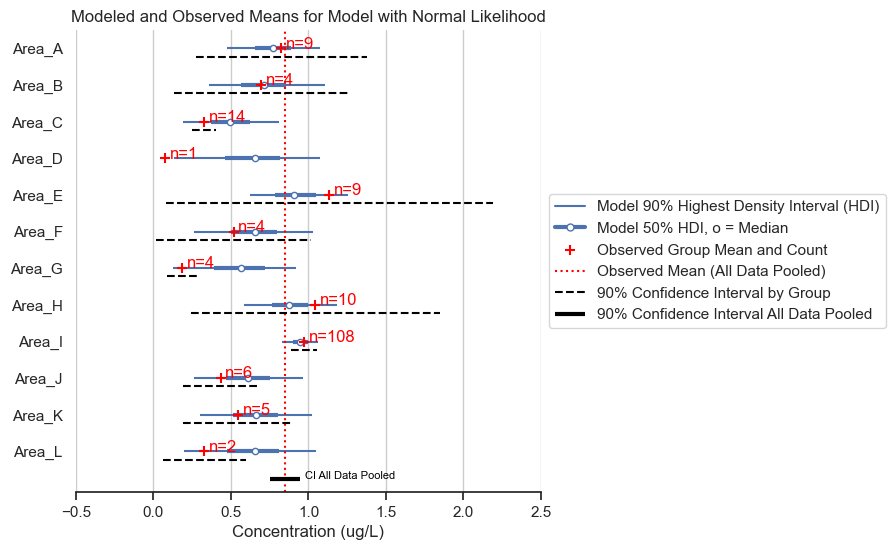

In [29]:
fig, ax = posterior_forest_area_plot(trace, 
            hierarchical_stormwater_nitrate_normal_like,
            obs_data, factor_var='area_mu',
            title='Modeled and Observed Means for Model with Normal Likelihood')

The normal likelihood model gives almost identical results for the posterior means.  However, we expect that the posterior predictive will give data of a different shape.  Let's see if that is the case.      

In [30]:
hierarchical_stormwater_nitrate_normal_like.set_data('area_idx', area_idxs)
with hierarchical_stormwater_nitrate_normal_like:
    post_pred = pm.sample_posterior_predictive(trace)

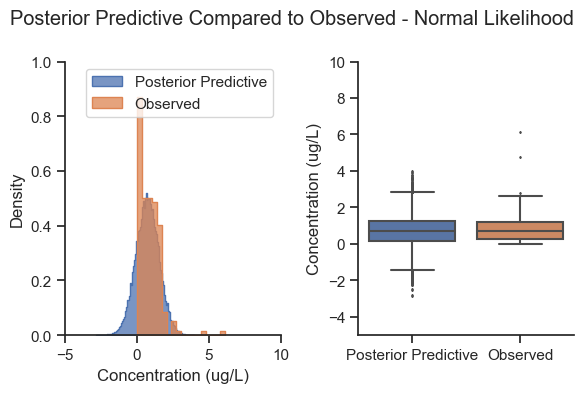

In [31]:
plot_data = pd.DataFrame()
plot_data['Posterior Predictive'] = post_pred.posterior_predictive['C_modeled'].values.flatten()
missing_n = (len(plot_data['Posterior Predictive']) -
            len(obs_data.Value.values))
plot_data['Observed'] = list(obs_data.Value.values) + [np.nan]*missing_n

plot_predictive(plot_data, prior_posterior='Posterior Predictive', 
                fliersize=1, conc_limits=(-5,10),
                title='Posterior Predictive Compared to Observed - Normal Likelihood')

plt.tight_layout()

As expected, the posterior predictive produces negative values that are not consistent with the distribution of the data, and a smaller tail on the right side of the distribution.  In this situation, the normal likelihood was adequate for estimating the posterior parameter mean values, but not accurate for simulating data.

#### LogNormal Likelihood
It is common to lognormalize concentration data prior to analysis.  This can also be achieved by using the lognormal distribution in Pymc.  In this case, we'll lognormalize the data and use the normal distribution model.    

In [32]:
with pm.Model() as hierarchical_stormwater_nitrate_normal_like_log_data:
    # Data
    C_obs_log = pm.MutableData('C_obs_log', np.log(obs_data.Value.values))
    area_idx = pm.MutableData('area_idx', obs_data.Area_idx.values)
    
    # Hyperpriors
    area_mu_mu = pm.Normal('area_mu_mu', mu=0, sigma=5)
    area_mu_sigma= pm.Exponential('area_mu_sigma', 1) 

    # Prior
    area_mu = pm.Normal('area_mu', mu=area_mu_mu, sigma=area_mu_sigma, 
                                 shape=len(areas))

    # Prior sigma
    sigma = pm.TruncatedNormal('sigma', mu=1,  sigma=5, lower=0)
    
    pm.Deterministic('area_mu_natural_units', pm.math.exp(area_mu + sigma**2 / 2))
    # Likelihood  
    mu = area_mu[area_idx]    # Indexed mu for each datapoint
    C_modeled_log = pm.Normal('C_modeled_log', mu=mu, sigma=sigma, observed=C_obs_log)

hierarchical_stormwater_nitrate_normal_like_log_data

           area_mu_mu ~ N(0, 5)
        area_mu_sigma ~ Exp(f())
              area_mu ~ N(area_mu_mu, area_mu_sigma)
                sigma ~ TruncatedNormal(1, 5, 0, inf)
area_mu_natural_units ~ Deterministic(f(area_mu, sigma))
        C_modeled_log ~ N(f(area_mu), sigma)

In [33]:
with hierarchical_stormwater_nitrate_normal_like_log_data:
    trace = pm.sample(target_accept=.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [area_mu_mu, area_mu_sigma, area_mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 84 seconds.


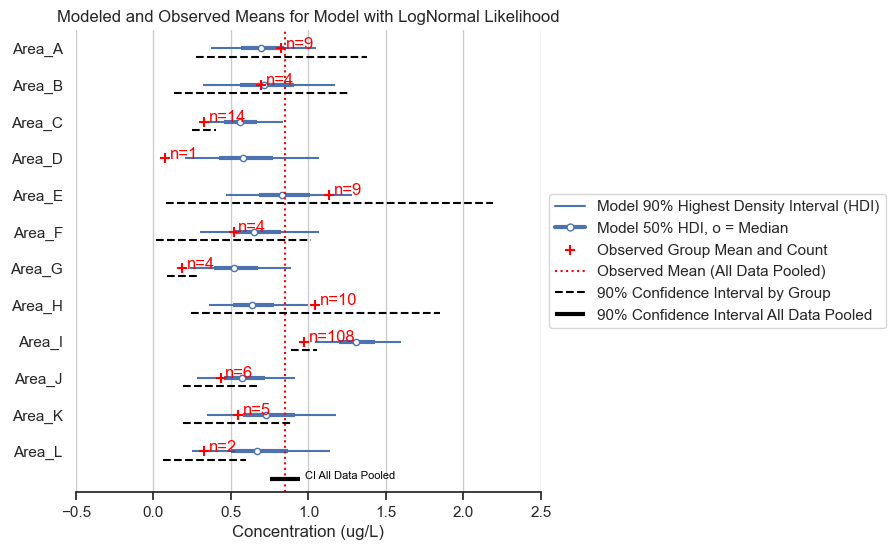

In [34]:
fig, ax = posterior_forest_area_plot(trace, 
            hierarchical_stormwater_nitrate_normal_like_log_data,
            obs_data, factor_var='area_mu_natural_units',
            title='Modeled and Observed Means for Model with LogNormal Likelihood')

There are some counter-intuitive results.  Most areas show shrinkage, except Area I, which has predictions that are higher than the observed mean.  A posterior predictive check (with concentrations converted back to natural units) will help us to figure out why.    

In [35]:
hierarchical_stormwater_nitrate_normal_like_log_data.set_data('area_idx', area_idxs)
with hierarchical_stormwater_nitrate_normal_like_log_data:
    post_pred = pm.sample_posterior_predictive(trace)

(0.0, 7.0)

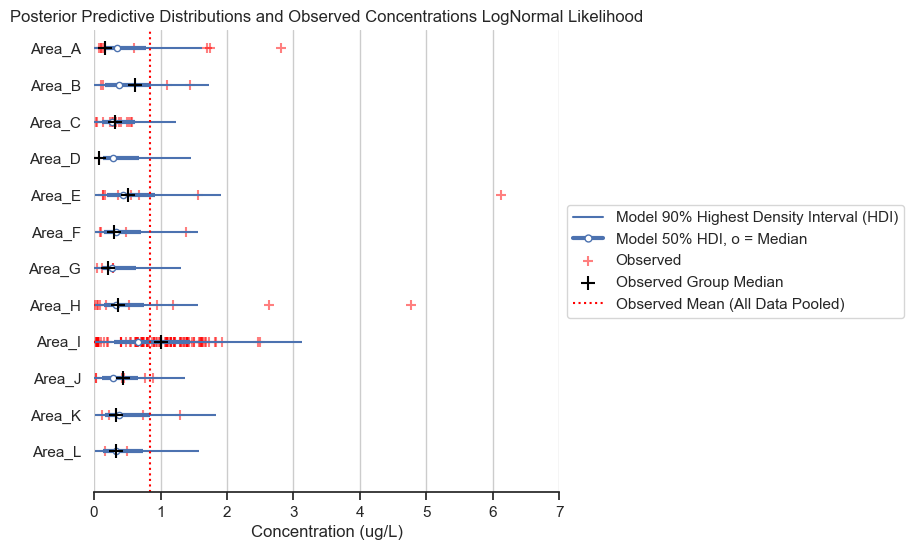

In [36]:
fig, ax = posterior_forest_area_plot(post_pred, hierarchical_stormwater_nitrate_normal_like_log_data,
            obs_data, factor_var='C_modeled_log', observed_means_all = 'all_medians', 
            posterior_posterior_pred = 'posterior_pred_log', CIs=False,
            title='Posterior Predictive Distributions and Observed Concentrations LogNormal Likelihood')
ax.set_xlim(0, 7)

In the chart above, I have plotted the group medians as black plusses.  Notice that the median for Area I is well above that of the other areas.  Recall that the lognormal distribution fits the geometric mean (which maps onto the median), rather than the arithmetic mean of the data.  Therefore, the lognormal distribution not providing a good fit for Area I, which is less skewed than data for other areas (i.e., the median is closer to the mean). 

While the lognormal distribution likelihood does not work well with this dataset, this result does beg the question about why Area I is less skewed than the other areas and how that might impact the analysis.  But this is beyond the scope of this analysis.  

## Next Steps

This notebook runs through a heirarchical regression model including the components for a complete Bayesian analysis, as outlined in Notebook #2.  The next notebook will recast a historical environmental analysis in a Bayesian wrapper.  